LangGraph Node Flow System Example

Graph Structure:
----------------------------------------------------------------------
num1 (int):
  Outputs: ['add1']
num2 (int):
  Outputs: ['add1', 'add2']
num3 (float):
  Outputs: ['subtract1']
text1 (text):
add1 (add):
  Inputs: {'input_a': 'num1', 'input_b': 'num2'}
  Outputs: ['subtract1']
subtract1 (subtract):
  Inputs: {'input_a': 'add1', 'input_b': 'num3'}
  Outputs: ['add2']
add2 (add):
  Inputs: {'input_a': 'subtract1', 'input_b': 'num2'}
  Outputs: ['conditional1']
conditional1 (conditional):
  Inputs: {'condition_input': 'add2'}

Building and executing graph...
----------------------------------------------------------------------


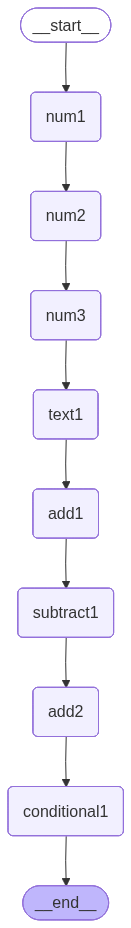

Hello World

Execution Order:
----------------------------------------------------------------------
1. num1
2. num2
3. num3
4. text1
5. add1
6. subtract1
7. add2
8. conditional1

Node Values:
----------------------------------------------------------------------
num1: 10 (type: int)
num2: 5 (type: int)
num3: 3.5 (type: float)
text1: Hello World (type: str)
add1: 15 (type: int)
subtract1: 11.5 (type: float)
add2: 16.5 (type: float)
conditional1: True (type: bool)

Computation Flow:
----------------------------------------------------------------------
num1 = 10
num2 = 5
num3 = 3.5
add1 = num1 + num2 = 15
subtract1 = add1 - num3 = 11.5
add2 = subtract1 + num2 = 16.5
conditional1 = (add2 > 10) = True

✓ Graph executed successfully!


In [ ]:
"""
LangGraph-based Node Flow System
A complex node flow system with typed nodes and state management
"""

from typing import TypedDict, Annotated, Any, Dict, List, Union
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
import operator
from IPython.display import Image, display

# ============================================================================
# STATE DEFINITION
# ============================================================================


class NodeFlowState(TypedDict):
    """Global state that tracks all node values and execution flow"""

    node_values: Dict[str, Any]  # Stores computed values for each node
    execution_order: List[str]  # Tracks which nodes have been executed
    current_node: str  # Current node being processed
    error: str  # Error messages if any


# ============================================================================
# BASE NODE CLASS
# ============================================================================


class BaseNode:
    """Base class for all node types"""

    def __init__(self, node_id: str, node_type: str):
        self.node_id = node_id
        self.node_type = node_type
        self.inputs = {}  # Maps input_name -> source_node_id
        self.outputs = []  # List of nodes that use this node's output

    def add_input(self, input_name: str, source_node_id: str):
        """Connect an input from another node"""
        self.inputs[input_name] = source_node_id

    def add_output(self, target_node_id: str):
        """Register that this node feeds into another node"""
        if target_node_id not in self.outputs:
            self.outputs.append(target_node_id)

    def get_input_values(self, state: NodeFlowState) -> Dict[str, Any]:
        """Retrieve values from connected input nodes"""
        input_values = {}
        for input_name, source_node_id in self.inputs.items():
            if source_node_id in state["node_values"]:
                input_values[input_name] = state["node_values"][source_node_id]
            else:
                raise ValueError(f"Input node {source_node_id} has no computed value")
        return input_values

    def execute(self, state: NodeFlowState) -> NodeFlowState:
        """Execute this node and update state - to be overridden"""
        raise NotImplementedError("Subclasses must implement execute()")


# ============================================================================
# CONCRETE NODE IMPLEMENTATIONS
# ============================================================================


class TextNode(BaseNode):
    """Node that holds a text value"""

    def __init__(self, node_id: str, value: str):
        super().__init__(node_id, "text")
        self.value = value

    def execute(self, state: NodeFlowState) -> NodeFlowState:
        state["node_values"][self.node_id] = self.value
        print(self.value)
        state["execution_order"].append(self.node_id)
        return state


class IntNode(BaseNode):
    """Node that holds an integer value"""

    def __init__(self, node_id: str, value: int):
        super().__init__(node_id, "int")
        self.value = value

    def execute(self, state: NodeFlowState) -> NodeFlowState:
        state["node_values"][self.node_id] = self.value
        state["execution_order"].append(self.node_id)
        return state


class FloatNode(BaseNode):
    """Node that holds a float value"""

    def __init__(self, node_id: str, value: float):
        super().__init__(node_id, "float")
        self.value = value

    def execute(self, state: NodeFlowState) -> NodeFlowState:
        state["node_values"][self.node_id] = self.value
        state["execution_order"].append(self.node_id)
        return state


class AddNode(BaseNode):
    """Node that adds two numeric inputs"""

    def __init__(self, node_id: str):
        super().__init__(node_id, "add")

    def execute(self, state: NodeFlowState) -> NodeFlowState:
        inputs = self.get_input_values(state)

        if "input_a" not in inputs or "input_b" not in inputs:
            state["error"] = f"AddNode {self.node_id} missing inputs"
            return state

        result = inputs["input_a"] + inputs["input_b"]
        state["node_values"][self.node_id] = result
        state["execution_order"].append(self.node_id)
        return state


class SubtractNode(BaseNode):
    """Node that subtracts input_b from input_a"""

    def __init__(self, node_id: str):
        super().__init__(node_id, "subtract")

    def execute(self, state: NodeFlowState) -> NodeFlowState:
        inputs = self.get_input_values(state)

        if "input_a" not in inputs or "input_b" not in inputs:
            state["error"] = f"SubtractNode {self.node_id} missing inputs"
            return state

        result = inputs["input_a"] - inputs["input_b"]
        state["node_values"][self.node_id] = result
        state["execution_order"].append(self.node_id)
        return state


class ConditionalNode(BaseNode):
    """Node that routes based on a condition (value > threshold)"""

    def __init__(self, node_id: str, threshold: float = 0):
        super().__init__(node_id, "conditional")
        self.threshold = threshold

    def execute(self, state: NodeFlowState) -> NodeFlowState:
        inputs = self.get_input_values(state)

        if "condition_input" not in inputs:
            state["error"] = f"ConditionalNode {self.node_id} missing condition_input"
            return state

        # Store boolean result
        result = inputs["condition_input"] > self.threshold
        state["node_values"][self.node_id] = result
        state["execution_order"].append(self.node_id)
        return state


# ============================================================================
# NODE FLOW GRAPH BUILDER
# ============================================================================


class NodeFlowGraph:
    """Manages the node flow graph using LangGraph"""

    def __init__(self):
        self.nodes: Dict[str, BaseNode] = {}
        self.graph = None

    def add_node(self, node: BaseNode):
        """Add a node to the graph"""
        self.nodes[node.node_id] = node

    def connect(self, source_id: str, target_id: str, input_name: str):
        """Connect two nodes"""
        if source_id not in self.nodes or target_id not in self.nodes:
            raise ValueError(f"Both nodes must exist: {source_id} -> {target_id}")

        target_node = self.nodes[target_id]
        target_node.add_input(input_name, source_id)

        source_node = self.nodes[source_id]
        source_node.add_output(target_id)

    def build_graph(self):
        """Build the LangGraph execution graph"""
        workflow = StateGraph(NodeFlowState)

        # Add all nodes to the workflow
        for node_id, node in self.nodes.items():
            workflow.add_node(node_id, node.execute)

        # Determine execution order using topological sort
        execution_order = self._topological_sort()

        # Add edges in execution order
        for i in range(len(execution_order) - 1):
            workflow.add_edge(execution_order[i], execution_order[i + 1])

        # Set entry point and finish
        if execution_order:
            workflow.set_entry_point(execution_order[0])
            workflow.add_edge(execution_order[-1], END)

        self.graph = workflow.compile()
        display(Image(self.graph.get_graph().draw_mermaid_png()))
        
        return self.graph

    def _topological_sort(self) -> List[str]:
        """Perform topological sort to determine execution order"""
        # Calculate in-degree for each node
        in_degree = {node_id: len(node.inputs) for node_id, node in self.nodes.items()}

        # Find all nodes with no inputs (starting nodes)
        queue = [node_id for node_id, degree in in_degree.items() if degree == 0]
        result = []

        while queue:
            current = queue.pop(0)
            result.append(current)

            # Reduce in-degree for dependent nodes
            for output_node_id in self.nodes[current].outputs:
                in_degree[output_node_id] -= 1
                if in_degree[output_node_id] == 0:
                    queue.append(output_node_id)

        if len(result) != len(self.nodes):
            raise ValueError("Graph contains cycles!")

        return result

    def execute(self) -> NodeFlowState:
        """Execute the entire graph"""
        if not self.graph:
            self.build_graph()

        initial_state = NodeFlowState(
            node_values={}, execution_order=[], current_node="", error=""
        )

        final_state = self.graph.invoke(initial_state)
        return final_state


# ============================================================================
# EXAMPLE USAGE
# ============================================================================


def main():
    """Demonstrate the node flow system"""

    print("=" * 70)
    print("LangGraph Node Flow System Example")
    print("=" * 70)

    # Create the graph
    flow = NodeFlowGraph()

    # Create value nodes
    num1 = IntNode("num1", 10)
    num2 = IntNode("num2", 5)
    num3 = FloatNode("num3", 3.5)
    text1 = TextNode("text1", "Hello World")

    # Create operation nodes
    add1 = AddNode("add1")
    subtract1 = SubtractNode("subtract1")
    add2 = AddNode("add2")
    conditional1 = ConditionalNode("conditional1", threshold=10)

    # Add all nodes to the graph
    for node in [num1, num2, num3, text1, add1, subtract1, add2, conditional1]:
        flow.add_node(node)

    # Connect nodes to create the flow:
    # add1 = num1 + num2 (10 + 5 = 15)
    flow.connect("num1", "add1", "input_a")
    flow.connect("num2", "add1", "input_b")

    # subtract1 = add1 - num3 (15 - 3.5 = 11.5)
    flow.connect("add1", "subtract1", "input_a")
    flow.connect("num3", "subtract1", "input_b")

    # add2 = subtract1 + num2 (11.5 + 5 = 16.5)
    flow.connect("subtract1", "add2", "input_a")
    flow.connect("num2", "add2", "input_b")

    # conditional1 checks if add2 > 10 (16.5 > 10 = True)
    flow.connect("add2", "conditional1", "condition_input")

    print("\nGraph Structure:")
    print("-" * 70)
    for node_id, node in flow.nodes.items():
        print(f"{node_id} ({node.node_type}):")
        if node.inputs:
            print(f"  Inputs: {node.inputs}")
        if node.outputs:
            print(f"  Outputs: {node.outputs}")

    # Build and execute the graph
    print("\nBuilding and executing graph...")
    print("-" * 70)

    result = flow.execute()

    # Display results
    print("\nExecution Order:")
    print("-" * 70)
    for i, node_id in enumerate(result["execution_order"], 1):
        print(f"{i}. {node_id}")

    print("\nNode Values:")
    print("-" * 70)
    for node_id, value in result["node_values"].items():
        print(f"{node_id}: {value} (type: {type(value).__name__})")

    print("\nComputation Flow:")
    print("-" * 70)
    print(f"num1 = {result['node_values']['num1']}")
    print(f"num2 = {result['node_values']['num2']}")
    print(f"num3 = {result['node_values']['num3']}")
    print(f"add1 = num1 + num2 = {result['node_values']['add1']}")
    print(f"subtract1 = add1 - num3 = {result['node_values']['subtract1']}")
    print(f"add2 = subtract1 + num2 = {result['node_values']['add2']}")
    print(f"conditional1 = (add2 > 10) = {result['node_values']['conditional1']}")

    if result["error"]:
        print(f"\nError: {result['error']}")
    else:
        print("\n✓ Graph executed successfully!")

    print("=" * 70)


if __name__ == "__main__":
    main()